In [24]:
# CONFIG:
MODEL_PATH = 'models/model_360_epoch-2_kappa-0.653.pt'
MODEL_PATH = 'models/model_512px_epoch-9_kappa-0.676.pt'
MODEL_PATH = 'models/model_512px_epoch-17_kappa-0.651.pt'
MODEL_PATH = 'models/model_512px_epoch-12_kappa-0.645.pt'
MODEL_PATH = 'models/model_512px_epoch-11_kappa-0.624.pt'




INPUT_SIZE = 512

BY_CATEGORIES = False

single_model_14 = False#True

/home/bohdan/work/ml/programs/anaconda3/envs/bone/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 13/3197 [00:00<00:26, 120.52it/s]

valid_df shape: (3197, 4)


100%|██████████| 3197/3197 [00:48<00:00, 66.43it/s] 

Few images with shape: (512, 512)


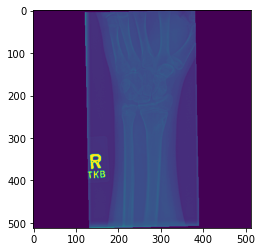

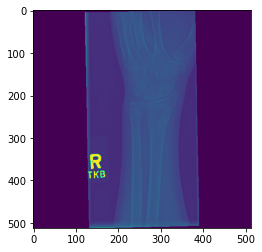

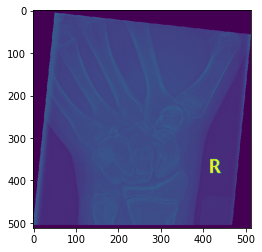

Loaded 3197 images and 3197 labels for the current dataset
unique studies: 1199


In [2]:
import time
import cv2
import argparse
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.ion()   # interactive mode

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter
# from tensorboard_utils import *

from model import PretrainedDensenet
from read_data import Data
from datasets_gpu import *#MuraDataset
from train import *
from loss import Loss
from visualize import see_samples, view_data_count

device = torch.device("cuda")

df = Data()
valid_df = df.valid_df
valid_labels_data = df.valid_labels_data


print("valid_df shape:", valid_df.shape)
body_type = 'WRIST'
# valid_df = valid_df[valid_df['BodyPart']==body_type]

val_transform = transforms.Compose([
#         transforms.Resize(INPUT_SIZE),
#             transforms.RandomCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
if not single_model_14:
    val_dataset = MuraDataset(df=valid_df, transform=val_transform)
    val_loader = DataLoader(dataset=val_dataset, batch_size=1, num_workers=0, shuffle=False)#, pin_memory=True)

if not single_model_14:
    model = PretrainedDensenet()
    model.to(device)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()

valid_df['study'] = valid_df['FilePath'].apply(lambda x: '/'.join(x.split('/')[:-1]))
print("unique studies:", valid_df['study'].nunique())

original_valid_df = valid_df.copy()

In [3]:
if single_model_14:
    from best_single import *

In [4]:
# Eval single 
def eval_trained_model():
    with torch.no_grad():
        model.eval()
        list_outputs = []
        list_labels = []
        for images, labels in tqdm(val_loader):
            images, labels = Variable(images.to(device)), Variable(labels.to(device))
            labels = labels.view(-1,1)

            output = model(images)

            # save output and labels for kappa_score
            outputs = output.cpu().numpy() # np.where(output.cpu().numpy() >= 0.5, 1, 0)
            list_outputs.extend(outputs.tolist())
    list_outputs = [el[0] for el in list_outputs]
    return list_outputs

In [5]:
# Eval single 
def eval_single14():
    list_outputs = []
    for FilePath in tqdm(valid_df['FilePath'].values):
        image = cv2.imread(FilePath)
        output = predict_image(image)
        list_outputs.append(output)
    return list_outputs


In [25]:
model = PretrainedDensenet()
model.to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
15

15

In [26]:
valid_df = original_valid_df

In [27]:
print(" Predicting for validation dataset with size of {0}*{0}".format(str(INPUT_SIZE)))

if single_model_14:
    list_outputs = eval_single14()
else:
    list_outputs = eval_trained_model()

  0%|          | 3/3197 [00:00<01:58, 26.97it/s]

 Predicting for validation dataset with size of 512*512


100%|██████████| 3197/3197 [01:29<00:00, 35.56it/s]


In [28]:
# Calculate average prediction for the whole study

valid_df['single_pred'] = list_outputs

valid_df_grouped = valid_df.groupby('study', as_index=False)['single_pred'].agg(np.mean)
valid_df = valid_df.merge(valid_df_grouped, left_on='study', right_on='study',
          suffixes=('', '_mean'))

valid_df_study = valid_df.drop_duplicates('study').reset_index()
avg_pred_label = [1 if x >=0.5 else 0 for x in valid_df_study['single_pred_mean'].to_list()]
valid_df_study['avg_pred_label'] = avg_pred_label

print("valid_df_study.shape:", valid_df_study.shape)
valid_df_study.head()

valid_df_study.shape: (1199, 9)


,index,FilePath,Label,BodyPart,StudyType,study,single_pred,single_pred_mean,avg_pred_label
0,0,../data/input/MURA-v1.1/valid/XR_WRIST/patient...,1,WRIST,study1,../data/input/MURA-v1.1/valid/XR_WRIST/patient...,0.999545,0.862918,1
1,4,../data/input/MURA-v1.1/valid/XR_WRIST/patient...,1,WRIST,study1,../data/input/MURA-v1.1/valid/XR_WRIST/patient...,0.999608,0.999769,1
2,6,../data/input/MURA-v1.1/valid/XR_WRIST/patient...,1,WRIST,study2,../data/input/MURA-v1.1/valid/XR_WRIST/patient...,0.998232,0.998190,1
3,9,../data/input/MURA-v1.1/valid/XR_WRIST/patient...,1,WRIST,study3,../data/input/MURA-v1.1/valid/XR_WRIST/patient...,0.999493,0.995182,1
4,12,../data/input/MURA-v1.1/valid/XR_WRIST/patient...,1,WRIST,study1,../data/input/MURA-v1.1/valid/XR_WRIST/patient...,0.436294,0.436294,0


In [29]:
list_outputs = valid_df_study['avg_pred_label'].to_list()
list_labels = valid_df_study['Label'].to_list()

print("LEN list_outputs:", len(list_outputs))

# -------------------------- metrics
# Kappa statistics
kappa_score = cohen_kappa_score(list_outputs, list_labels)
# AUC ROC
auc_roc_score = roc_auc_score(list_outputs, list_labels)
# accuracy
accuracy = accuracy_score(list_outputs, list_labels)

print (f"\nKappa score : {kappa_score} \nAUC ROC score : {auc_roc_score} \nAccuracy : {accuracy}")

LEN list_outputs: 1199

Kappa score : 0.6688713591382354 
AUC ROC score : 0.8337278272060881 
Accuracy : 0.835696413678065
